# Importo las librerías necesarias y mi df

In [137]:
#%cd "C:\"

In [138]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [139]:
from nltk.corpus import stopwords
import re
import pandas as pd
#En entorno local
#df = pd.read_csv('C:\Users\Usuario\Downloads\Solucionador_dataset.csv', on_bad_lines='warn')
df = pd.read_csv('Solucionador_dataset.csv', on_bad_lines='warn')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
"""import spacy
! python -m spacy download es_core_news_md"""

'import spacy\n! python -m spacy download es_core_news_md'

In [140]:
df.head(5)

,Ejercicio;Tema
0,Un tren que viaja a 20 m s cruza un puente en...
1,De dos puntos distintos A y B separados 250 m...
2,2 trenes parten simultaneamente uno de P y otr...
3,Una particula que viaja con velocidad constant...
4,Deducir las velocidades supuestas constantes d...


Divido las columnas

In [141]:
df['Ejercicio;Tema'].str.split(';', expand=True)

,0,1
0,Un tren que viaja a 20 m s cruza un puente en...,mru
1,De dos puntos distintos A y B separados 250 m...,mru
2,2 trenes parten simultaneamente uno de P y otr...,mru
3,Una particula que viaja con velocidad constant...,mru
4,Deducir las velocidades supuestas constantes d...,mru
...,...,...
1392,Un astronauta en la luna arrojo un objeto vert...,tv
1393,Suponga que un objeto fuese lanzado verticalme...,tv
1394,Se arroja una piedra verticalmente hacia arrib...,tv
1395,Un edificio mide 18 metros de altura Una perso...,tv


In [142]:
df[['Ejercicio', 'Tema']] = df['Ejercicio;Tema'].str.split(';', expand=True)
# display the dataframe
del df['Ejercicio;Tema']

# Elimino los datos replicados y vacíos

In [143]:
df.isnull().sum()

Ejercicio    0
Tema         0
dtype: int64

In [144]:
df.shape

(1397, 2)

In [145]:
df.drop_duplicates(inplace=True)

In [146]:
df.shape

(1340, 2)

# Preproceso los datos

## Eliminación de caracteres especiales

In [147]:
print(df['Ejercicio'].apply(lambda x: len(x.split(' '))).sum())

63978


In [148]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [149]:
special_character_remover = re.compile('[/(){}\[\]\|@,;]')
extra_symbol_remover = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('spanish'))

In [150]:
def clean_text(text):
    text = text.lower()
    text = special_character_remover.sub(' ', text)
    text = extra_symbol_remover.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
    
df['Ejercicio'] = df['Ejercicio'].apply(clean_text)

In [151]:
print(df['Ejercicio'].apply(lambda x: len(x.split(' '))).sum())

35491


In [152]:
print(clean_text("Un movil se desplaza con aceleracion angular de 3 rad / s2, otro se desplaza con velocidad constante. Cuando se van a encontrar ambos moviles"))

movil desplaza aceleracion angular 3 rad s2 desplaza velocidad constante van encontrar ambos moviles


## Lematización con Spacy

In [ ]:
"""nlp = spacy.load("es_core_news_md")

df['Ejercicio']= df['Ejercicio'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))
"""

## Stemming

In [57]:
"""df["Ejercicio"]= df["Ejercicio"].str.split(" ", expand = False)
df"""

'df["Ejercicio"]= df["Ejercicio"].str.split(" ", expand = False)\ndf'

In [58]:
"""from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')
df['Ejercicio'] = df['Ejercicio'].apply(lambda x: [spanish_stemmer.stem(y) for y in x]) # Stem every word.
df # Print dataframe."""

"from nltk.stem import SnowballStemmer\nspanish_stemmer = SnowballStemmer('spanish')\ndf['Ejercicio'] = df['Ejercicio'].apply(lambda x: [spanish_stemmer.stem(y) for y in x]) # Stem every word.\ndf # Print dataframe."

In [59]:
"""df['Ejercicio'] = df["Ejercicio"].str.join(" ")
df"""

'df[\'Ejercicio\'] = df["Ejercicio"].str.join(" ")\ndf'

## Tfidf y countvectorizer

In [153]:
import sklearn
df=sklearn.utils.shuffle(df)

In [154]:
vectorizer=TfidfVectorizer(min_df=1, max_df=0.9, decode_error='warn')
vectorized=vectorizer.fit_transform(df.Ejercicio)

count_vectorizer=CountVectorizer(min_df=1, max_df=0.9, decode_error='warn')
count_vectorized=count_vectorizer.fit_transform(df.Ejercicio)

In [155]:
import scipy.sparse
X = scipy.sparse.hstack([vectorized, count_vectorized])
#X = vectorized

In [156]:
X = X.toarray()

In [157]:
X.shape

(1340, 7832)

# Divido mi dataset

*Recordar que X se convirtió en los datos en Ejercicios preprocesados*

In [158]:
# Para usar el SParse Categorical Crossentropy
from sklearn.model_selection import train_test_split
#Defino a que número pertenecería cada clase y los reemplazo con un for evaluando si la llave del diccionaro coincide con lo que el for itere
mapping = {'mru': 0, 'mruv': 1, 'tv': 2, 'tob': 3, 'mcu': 4, 'mcuv': 5}
#df.Tema = [mapping[item] for item in df.Tema]
y = df.Tema
y = y.to_numpy()
cont = 0
for i in y:
  for key in mapping:
    if key == y[cont]:
      y[cont] = mapping[key]
  cont+=1
y = np.asarray(y).astype('int')
y

array([1, 2, 0, ..., 3, 2, 4])

In [159]:
X_train_xg, X_test_xg, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train = X_train_xg.reshape(X_train_xg.shape[0], 1, X_train_xg.shape[1]) 
X_test = X_test_xg.reshape(X_test_xg.shape[0], 1, X_test_xg.shape[1]) 
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1072, 1, 7832), (268, 1, 7832), (1072,), (268,))

In [160]:
y_classes = [0, 0, 0, 0, 0, 0]
for i in y_train:
    y_classes[i] += 1
y_classes

[197, 190, 173, 213, 170, 129]

# Creo el modelo y lo entreno

In [85]:
"""#Modelo con Sklearn Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

lr = Pipeline([
               ('clf', LogisticRegression()),
              ])

lr.fit(X_train,y_train)
y_predtrain = lr.predict(X_train)
y_pred1 = lr.predict(X_test)

print(f"Accuracy is : {accuracy_score(y_pred1,y_test)}")"""

'#Modelo con Sklearn Pipeline\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.feature_extraction.text import TfidfTransformer\n\nlr = Pipeline([\n               (\'clf\', LogisticRegression()),\n              ])\n\nlr.fit(X_train,y_train)\ny_predtrain = lr.predict(X_train)\ny_pred1 = lr.predict(X_test)\n\nprint(f"Accuracy is : {accuracy_score(y_pred1,y_test)}")'

In [161]:
#Con XGBoost
from xgboost import XGBClassifier
model_xg = XGBClassifier()
model_xg.fit(X_train_xg, y_train)
y_preds = model_xg.predict(X_test_xg)
#from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test,y_preds)
print(acc_score)

0.8507462686567164


In [166]:
#Modelo secuencial de GRU
model = keras.Sequential()
model.add(tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.GRU(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(layers.GRU(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(layers.GRU(64))
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dense(6, activation = "linear"))

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 1, 256)            6213120   
                                                                 
 gru_13 (GRU)                (None, 1, 128)            148224    
                                                                 
 gru_14 (GRU)                (None, 64)                37248     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 6)                 390       
                                                                 
Total params: 6,403,142
Trainable params: 6,403,142
Non-trainable params: 0
_________________________________________________________________


In [88]:
"""#Modelo funcional con LSTM
def Mi_modelo():
  input = keras.Input(shape=(X_train.shape[1], X_train.shape[2])
  x = layers.LSTM(256, return_sequences=True, return_state = True)(input)
  x = layers.LSTM(128, return_sequences=True, return_state = True)(x)
  x = layers.LSTM(64)(x)
  x = layers.Dense(64, activation = "relu")(x)
  output = layers.Dense(6, activation = "linear")(x)
  model = keras.Model(inputs=input, outputs=output)
  return model
  
model = Mi_modelo()  
model.compile(optimizer = "Adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ["accuracy"])
model.summary()"""

'#Modelo funcional con LSTM\ndef Mi_modelo():\n  input = keras.Input(shape=(X_train.shape[1], X_train.shape[2])\n  x = layers.LSTM(256, return_sequences=True, return_state = True)(input)\n  x = layers.LSTM(128, return_sequences=True, return_state = True)(x)\n  x = layers.LSTM(64)(x)\n  x = layers.Dense(64, activation = "relu")(x)\n  output = layers.Dense(6, activation = "linear")(x)\n  model = keras.Model(inputs=input, outputs=output)\n  return model\n  \nmodel = Mi_modelo()  \nmodel.compile(optimizer = "Adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ["accuracy"])\nmodel.summary()'

Entrenamiento del modelo y gráfico a traves del tiempo

In [168]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, verbose=1)

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
from matplotlib import pyplot as plt
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Epoch 1/10
34/34 [==============================] - 4s 112ms/step - loss: 0.8290 - accuracy: 0.9664 - val_loss: 1.2046 - val_accuracy: 0.8396
Epoch 2/10
34/34 [==============================] - 4s 111ms/step - loss: 0.7638 - accuracy: 0.9795 - val_loss: 1.1786 - val_accuracy: 0.8582
Epoch 3/10
34/34 [==============================] - 4s 113ms/step - loss: 0.7135 - accuracy: 0.9851 - val_loss: 1.1712 - val_accuracy: 0.8507
Epoch 4/10
34/34 [==============================] - 4s 111ms/step - loss: 0.6758 - accuracy: 0.9925 - val_loss: 1.1730 - val_accuracy: 0.8470
Epoch 5/10
22/34 [==================>...........] - ETA: 1s - loss: 0.6454 - accuracy: 0.9972

KeyboardInterrupt: ignored

# Matriz de confusión

In [92]:
from numpy import argmax
logit = tf.nn.softmax(model.predict(X_test))
y_predtest = argmax(logit, axis=1)
results = model.evaluate(X_test, y_test, batch_size=32)

9/9 [==============================] - 0s 50ms/step - loss: 0.7172 - accuracy: 0.8209


In [93]:
y_test

array([1, 0, 0, 5, 5, 2, 5, 2, 2, 1, 5, 1, 2, 3, 2, 1, 5, 0, 3, 3, 5, 3,
       0, 1, 0, 2, 4, 0, 2, 0, 0, 4, 4, 4, 5, 4, 5, 2, 0, 0, 3, 5, 1, 3,
       1, 2, 3, 4, 5, 4, 2, 3, 1, 5, 1, 2, 5, 0, 0, 3, 5, 3, 1, 4, 1, 1,
       3, 2, 5, 2, 3, 1, 0, 2, 0, 1, 4, 5, 0, 5, 4, 0, 3, 0, 5, 1, 4, 1,
       0, 4, 3, 3, 5, 5, 0, 3, 1, 2, 5, 4, 0, 2, 0, 0, 3, 2, 0, 4, 1, 1,
       4, 4, 0, 3, 2, 4, 4, 0, 3, 3, 2, 1, 4, 2, 3, 0, 2, 4, 5, 1, 1, 2,
       5, 1, 2, 4, 3, 5, 0, 2, 5, 2, 0, 2, 0, 3, 3, 0, 5, 5, 0, 3, 1, 2,
       0, 1, 3, 2, 1, 2, 2, 3, 5, 3, 0, 4, 3, 1, 3, 1, 4, 2, 3, 5, 1, 5,
       0, 2, 3, 0, 5, 0, 0, 0, 2, 2, 4, 3, 1, 0, 0, 4, 1, 1, 0, 3, 0, 5,
       3, 2, 5, 1, 1, 3, 0, 4, 3, 5, 0, 2, 0, 5, 1, 0, 0, 0, 0, 0, 3, 2,
       1, 1, 3, 0, 0, 0, 5, 1, 1, 2, 3, 1, 0, 4, 3, 4, 2, 0, 3, 4, 4, 1,
       1, 0, 5, 0, 2, 4, 4, 1, 1, 0, 3, 0, 0, 2, 2, 5, 4, 3, 0, 3, 2, 1,
       3, 0, 1, 3])

In [94]:
y_predtest

array([1, 0, 0, 5, 4, 2, 4, 2, 2, 1, 4, 1, 3, 3, 2, 0, 4, 0, 3, 3, 5, 3,
       0, 1, 1, 1, 4, 0, 2, 0, 0, 4, 4, 4, 4, 4, 5, 2, 0, 0, 3, 5, 1, 2,
       1, 2, 3, 4, 5, 4, 2, 3, 1, 5, 0, 2, 5, 0, 0, 3, 4, 0, 3, 4, 1, 1,
       3, 2, 1, 2, 3, 2, 0, 3, 0, 0, 4, 5, 0, 4, 4, 0, 3, 0, 5, 1, 4, 1,
       0, 4, 3, 3, 5, 5, 0, 3, 0, 2, 4, 4, 0, 2, 0, 0, 3, 3, 0, 4, 1, 1,
       4, 4, 0, 3, 2, 4, 4, 0, 3, 3, 2, 1, 4, 2, 4, 3, 2, 4, 5, 1, 1, 2,
       5, 1, 2, 5, 3, 1, 0, 2, 5, 2, 0, 2, 0, 3, 3, 0, 5, 5, 0, 3, 1, 2,
       0, 0, 3, 2, 1, 2, 2, 2, 5, 3, 0, 5, 3, 0, 3, 1, 5, 2, 3, 5, 1, 4,
       0, 3, 3, 0, 4, 0, 0, 0, 2, 2, 4, 3, 1, 0, 0, 0, 1, 1, 0, 3, 0, 5,
       3, 2, 5, 1, 1, 3, 0, 4, 3, 5, 1, 2, 0, 4, 1, 4, 1, 0, 1, 0, 3, 0,
       1, 1, 3, 0, 1, 0, 5, 0, 0, 3, 3, 1, 0, 5, 3, 4, 2, 0, 3, 4, 4, 1,
       1, 0, 5, 0, 2, 4, 4, 1, 1, 0, 3, 0, 0, 3, 2, 4, 4, 3, 0, 3, 2, 1,
       3, 0, 1, 3])

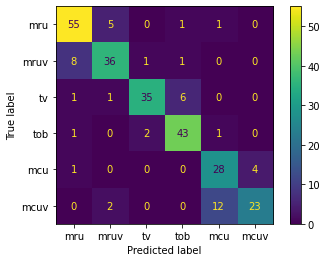

In [95]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_predtest)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["mru", "mruv", "tv", "tob", "mcu", "mcuv"])

cm_display.plot()
plt.show()

In [96]:
lista = [clean_text("Un movil se desplaza con aceleracion angular de 3 rad / s2, otro se desplaza con velocidad constante. Cuando se van a encontrar ambos moviles")]
lista_tf = vectorizer.transform(lista)
lista_cont = count_vectorizer.transform(lista)
lista = scipy.sparse.hstack([lista_tf, lista_cont])
lista = lista.toarray()
lista_gru = lista.reshape(lista.shape[0], 1,lista.shape[1])
pred_gru = tf.nn.softmax(model.predict(lista_gru))
pred_xg = model_xg.predict(lista)
for i in mapping:
  if mapping[i] == argmax(pred_gru, axis=1):
    print("Con GRU: " + i)
  if mapping[i] == pred_xg:
    print("Con XGBoost: " + i)
pred_gru

1/1 [==============================] - 0s 82ms/step
Con GRU: mcuv
Con XGBoost: mcuv


<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[2.6159804e-02, 7.7204734e-02, 6.5095723e-05, 6.4407749e-04,
        3.5587344e-01, 5.4005283e-01]], dtype=float32)>

#Salvar el modelo

In [99]:
model.save('modelo_GRU/')

In [91]:
modelo = keras.models.load_model('/content/modelo_GRU')
from numpy import argmax
logit_load = tf.nn.softmax(modelo.predict(X_test))
y_predtest_load = argmax(logit_load, axis=1)
results = modelo.evaluate(X_test, y_test, batch_size=32)

8/8 [==============================] - 1s 13ms/step - loss: 0.6205 - accuracy: 0.8565
